Classifying names on char level, basing on this tutorial:

https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html

## Read data and code to ASCII

In [26]:
import os
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

category_lines = {}
all_categories = []

for filename in os.listdir("data/names"):
    category = os.path.splitext(filename)[0]
    all_categories.append(category)

    with open(f"data/names/{filename}", "r") as f:
        lines = list(map(unicodeToAscii, f.readlines()))
        category_lines[category] = lines

n_categories = len(all_categories)


In [27]:
print(category_lines['Italian'][:5], n_categories)

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni'] 18


In [36]:
### turn names into tensors
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Turn a letter into a <1 x n_letters> Tensor in one-hot encoding
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# 1 because it's a batch of size 1
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for i, letter in enumerate(line):
        tensor[i][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))
lineToTensor('Jones').size()



tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])


torch.Size([5, 1, 57])

## Network

mostly from here: https://pytorch.org/tutorials/beginner/former_torchies/nnft_tutorial.html#example-2-recurrent-net

In [42]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size  = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size) # takes as an input the previous hidden layer and the current input
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1) # concat along dim 1
        hidden = self.i2h(combined)
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

# we pass one letter at a time (one-hot encoded), hidden state size is 128 and we want a probabilities of each language as output


In [43]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.9416, -2.9658, -2.9701, -2.9068, -2.8155, -2.8797, -2.8496, -2.9816,
         -2.8490, -2.8487, -2.8993, -2.9106, -2.9787, -2.8559, -2.8713, -2.8104,
         -2.8202, -2.8993]], grad_fn=<LogSoftmaxBackward0>)


## Training preparation

In [57]:
def categoryFromOutput(output):
    """ get a class with maximum probability and its' name """
    _, top_index = output.topk(1)
    top_index = top_index.item()
    return all_categories[top_index], top_index

print(categoryFromOutput(output))

('Scottish', 15)


In [68]:
import random

def randomTrainingExample():
    """ get a random training example and its' category as tensors """
    category = random.choice(all_categories)
    line = random.choice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long) # category number as tensor
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print(f'{category = }, {line = }')

category = 'Korean', line = 'Gil'
category = 'Portuguese', line = 'Matos'
category = 'Dutch', line = 'Daele'
category = 'Spanish', line = 'Viteri'
category = 'Polish', line = 'Wyrzyk'
category = 'Dutch', line = 'Altena'
category = 'Spanish', line = 'Agramunt'
category = 'Chinese', line = 'Won'
category = 'Czech', line = 'Safko'
category = 'Spanish', line = 'Oleastro'


## Training

In [75]:
criterion = nn.NLLLoss() # negative log likelihood loss
learning_rate = 0.005

def train(category_tensor, line_tensor):
    """ train the network on a single example """
    hidden = rnn.initHidden() # firstly we don't have any hidden state
    rnn.zero_grad() # zero the gradients

    for i in range(line_tensor.size()[0]): # iterate over each letter in the name
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor) # calculate loss
    loss.backward() # backpropagate

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()


In [79]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return f'{m}m {s:.0f}s'

start = time.time()

for iter in range(1, n_iters + 1):
    # train on a random example
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_index = categoryFromOutput(output) # get the guess
        correct = '✓' if guess == category else f'✗ ({category})'
        print(f'{iter = } – {iter/n_iters*100}% ({timeSince(start)}) {loss = :.4f} {line} | {guess} {correct}')

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every) # average loss over plot_every examples
        current_loss = 0

iter = 5000 – 5.0% loss = 0.2701 0m 7s line = 'Jedynak' | Polish ✓
iter = 10000 – 10.0% loss = 4.7441 0m 14s line = 'Loris' | Portuguese ✗ (German)
iter = 15000 – 15.0% loss = 0.9568 0m 21s line = 'Miazga' | Polish ✓
iter = 20000 – 20.0% loss = 0.2418 0m 28s line = 'Mersinias' | Greek ✓
iter = 25000 – 25.0% loss = 3.2411 0m 35s line = 'Sai' | Chinese ✗ (Vietnamese)
iter = 30000 – 30.0% loss = 3.7070 0m 42s line = 'Rooijakkers' | Polish ✗ (Dutch)
iter = 35000 – 35.0% loss = 0.4702 0m 49s line = 'Mo' | Korean ✓
iter = 40000 – 40.0% loss = 0.3933 0m 56s line = 'Segreti' | Italian ✓
iter = 45000 – 45.0% loss = 3.4658 1m 3s line = 'Ono' | Italian ✗ (Japanese)
iter = 50000 – 50.0% loss = 1.6303 1m 10s line = 'Cho' | Vietnamese ✗ (Korean)
iter = 55000 – 55.00000000000001% loss = 1.8199 1m 18s line = 'Arena' | Spanish ✗ (Italian)
iter = 60000 – 60.0% loss = 2.4379 1m 25s line = 'Kopp' | Dutch ✗ (Czech)
iter = 65000 – 65.0% loss = 4.9529 1m 32s line = 'Colling' | Irish ✗ (Czech)
iter = 70000 – 

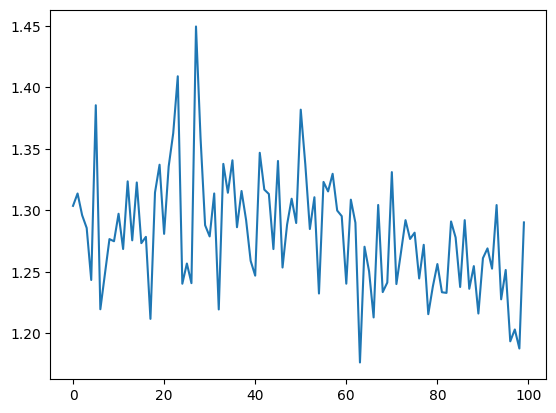

In [80]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(all_losses)

## Evaluate

/tmp/ipykernel_10535/385551774.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
/tmp/ipykernel_10535/385551774.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


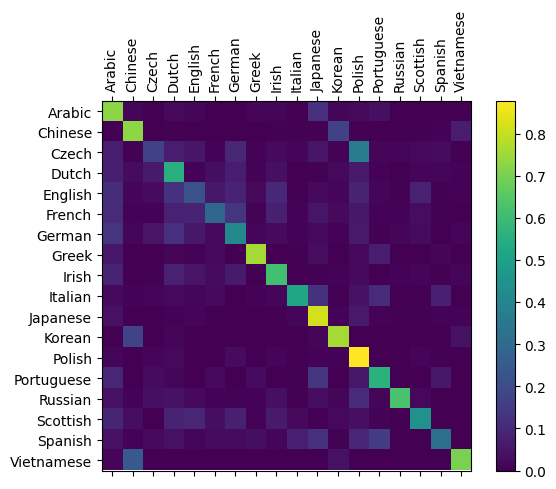

In [82]:
import matplotlib.ticker as ticker

confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000


def evaluate(line_tensor):
    """return an output given a line"""
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [84]:
def predict(input_line, n_predictions=3):
    print(f'\n> {input_line}')
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

In [85]:
predict('Dovesky')
predict('Jackson')
predict('Satoshi')
predict('Brzęczyszczykiewicz')
predict('Kowalski')


> Dovesky
(-0.90) Russian
(-1.52) Polish
(-1.52) Czech

> Jackson
(-0.70) Scottish
(-1.53) French
(-2.13) English

> Satoshi
(-0.90) Japanese
(-1.24) Polish
(-1.88) Arabic

> Brzęczyszczykiewicz
(-0.03) Polish
(-3.58) Czech
(-7.02) Dutch

> Kowalski
(-0.01) Polish
(-5.35) Czech
(-5.98) Japanese
